In [1]:
import sys
sys.path.append('../')

In [2]:
import copy
import torch
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from swapdae import AutoEncoder, SwapDAEPretrainer, DataPreprocessor
from swapdae.data import SwapNoiseDataset
from torch.utils.data import DataLoader, Dataset

# Load Data

In [3]:
data = pd.read_csv('adult.csv')
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


# Preprocessing

In [4]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [5]:
preprocessor = DataPreprocessor(num_indices=[0, 2, 4, 10, 11, 12], cate_indices=[1, 3, 5, 6, 7, 8, 9, 13])
X_train = preprocessor.fit_transform(X)

# Modeling

## Build model

In [6]:
model = AutoEncoder(
    input_dim = 14,
    encoder_hidden_dims = [64, 64, 16, 3],
    decoder_hidden_dims = [16, 64],
    cate_indices = [1, 3, 5, 6, 7, 8, 9, 13], 
    cardinalities = preprocessor.label_encoder.cardinalities,
    cate_embedding_dim = 2,
    dropout_rate = 0.1,
    activation = 'mish',
    is_bias = True,
    block_type = 'mlp'
)

## Init Trainer

In [7]:
from torch.optim import Adam

In [8]:
trainer = SwapDAEPretrainer(
    batch_size=1024,
    max_epochs=200,
    swap_prob=0.1,
    verbose=1
)

optimizer = Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-3, weight_decay=1e-5
)

trainer.register_optimizer(optimizer)

## Start Training

In [9]:
trainer.fit(model, X_train)

[Epoch][1][Loss][19.04624803860982]
[Epoch][2][Loss][16.958471685647964]
[Epoch][3][Loss][15.999234464433458]
[Epoch][4][Loss][15.448825523257256]
[Epoch][5][Loss][15.063438872496286]
[Epoch][6][Loss][14.817763219277063]
[Epoch][7][Loss][14.615580873829979]
[Epoch][8][Loss][14.444945774972439]
[Epoch][9][Loss][14.300953087983308]
[Epoch][10][Loss][14.186367028951645]
[Epoch][11][Loss][14.079517218199642]
[Epoch][12][Loss][13.986302334401342]
[Epoch][13][Loss][13.900537406786894]
[Epoch][14][Loss][13.819399545590082]
[Epoch][15][Loss][13.745832126670413]
[Epoch][16][Loss][13.68472327167789]
[Epoch][17][Loss][13.629358648085127]
[Epoch][18][Loss][13.574171559678184]
[Epoch][19][Loss][13.528283895107737]
[Epoch][20][Loss][13.480956896146138]
[Epoch][21][Loss][13.437253147836715]
[Epoch][22][Loss][13.39196536486799]
[Epoch][23][Loss][13.3530311593111]
[Epoch][24][Loss][13.317588307791286]
[Epoch][25][Loss][13.309644935131073]
[Epoch][26][Loss][13.295710492592592]
[Epoch][27][Loss][13.26998

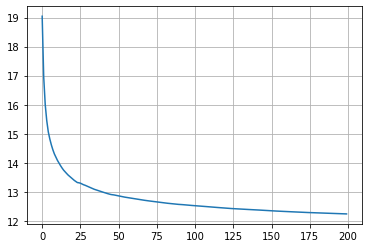

In [10]:
plt.plot(trainer.epoch_history['loss'])
plt.grid()
plt.show()

# Feature Extraction

In [11]:
@torch.no_grad()
def extract_features(model: AutoEncoder, data):
    data = pd.DataFrame(data) if isinstance(data, np.ndarray) else data
    
    data_loader = DataLoader(
        SwapNoiseDataset(data),
        batch_size=1024, shuffle=False, pin_memory=True, num_workers=0
    )
    
    reprs = None
    
    for i, data in enumerate(data_loader):
        _, x = data
        x = x.cuda()
        enc, _ = model(x)
        enc = enc.cpu().numpy()
        
        if i == 0:
            reprs = enc
        else:
            reprs = np.vstack((reprs, enc))
            
    return reprs

In [12]:
extracted_features = extract_features(model, X_train)

## KMeans Clustering

In [13]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [14]:
distortions = []
num_clusters = range(1, 10)
  
for k in num_clusters:
    km = KMeans(n_clusters=k).fit(extracted_features)  
    distortions.append(sum(np.min(cdist(extracted_features, km.cluster_centers_,
                                        'euclidean'), axis=1)) / extracted_features.shape[0])

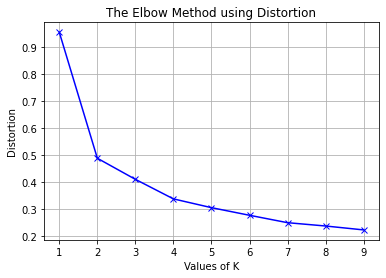

In [15]:
plt.plot(num_clusters, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.grid()
plt.show()

## Visulization

In [16]:
cls1_indices = np.where(y == '<=50K')[0]
cls2_indices = np.where(y == '>50K')[0]

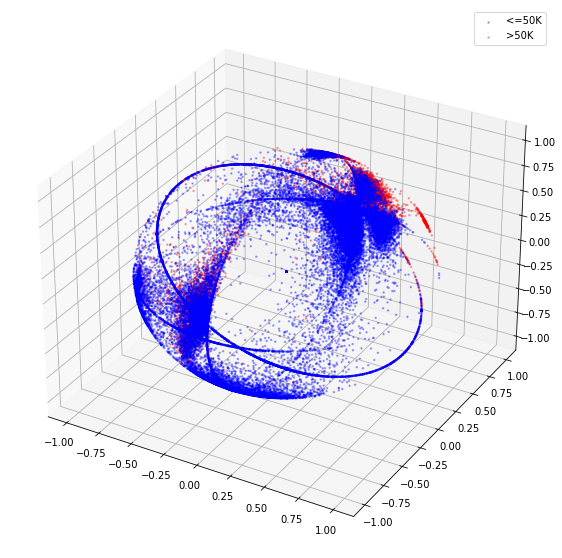

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

ax.scatter(
    extracted_features[cls1_indices, 0], 
    extracted_features[cls1_indices, 1], 
    extracted_features[cls1_indices, 2], 
    s=2, c='blue', alpha=0.3, label='<=50K'
)

ax.scatter(
    extracted_features[cls2_indices, 0], 
    extracted_features[cls2_indices, 1], 
    extracted_features[cls2_indices, 2], 
    s=2, c='red', alpha=0.3, label='>50K'
)

plt.legend()
plt.show()